In [1]:
import torch 
import torch.nn as nn 
import torch.nn.functional as f
import numpy as np 
from torch.utils.data import TensorDataset, DataLoader, random_split
import matplotlib.pyplot as plt 
import auto_encoder

In [2]:
get_dataset = auto_encoder.get_dataset
#data_2 = '2_qubit_crit_data.npz'
#data_4 = '4_qubit_crit_data.npz'
data_6 = '6_qubit_crit_data.npz'
#data_7 = '7_qubit_crit_data.npz'
#data_10 = '10_qubit_crit_data.npz'

#data_11 = '11_qubit_crit_data.npz'
#data_12 = '12_qubit_crit_data.npz'



training_n_sizes = [4]
validation_n_sizes = [6,2,4,7]


#training_data_2 = get_dataset(data_2, 2, 1000)
#training_data_4 = get_dataset(data_4,4,1600)
#training_data_7 = get_dataset(data_7,7,1000) 

#training_data_2, val_data_2 = random_split(training_data_2, [800,100])
#training_data_4, val_data_4 = random_split(training_data_4, [1500,100])
#training_data_7, val_data_7 = random_split(training_data_7, [900,100])

#training_data_10 = get_dataset(data_10,10,200)
#training_data_11 = get_dataset(data_11,11,200)
#training_data_12 = get_dataset(data_12,12,100)

datasets = [#training_data_2,
            training_data_4]
            #training_data_7]

training_loaders = [DataLoader(x, batch_size = 32,  shuffle=True, num_workers=20) for x in datasets]

#val_data_6 = get_dataset(data_6, 6, 1000)

#val_datasets = [val_data_6, val_data_2, val_data_4, val_data_7]

#val_loaders = [DataLoader(x, batch_size = 1000, num_workers=20) for x in val_datasets]

#test_loader_10 = DataLoader(training_data_10, batch_size = 200, num_workers = 20)
#test_loader_11 = DataLoader(training_data_11, batch_size = 200, num_workers = 20)
#test_loader_12 = DataLoader(training_data_12, batch_size = 100, num_workers = 20)

NameError: name 'training_data_4' is not defined

In [3]:
#warmup_2 = next(iter(training_loaders[0]))
warmup_4 = next(iter(training_loaders[0]))
#warmup_7 = next(iter(training_loaders[2]))


In [4]:
mps_size = 5
model = auto_encoder.MPS_autoencoder(mps_size = mps_size)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_func = nn.MSELoss(reduction='sum')

warmup_data = [(warmup_2,2), (warmup_4,4)]#, (warmup_7,7)]

for j in range(10):
    for i in range(2):
        for epoch in range(10):
            fields,wf = warmup_data[i][0]
            gs = model(fields, warmup_data[i][1])            
            loss = loss_func(gs, wf)
            if (epoch % 10 == 0):
                print(warmup_data[i][1],"\t", loss.item() *(2**warmup_data[i][1]))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

torch.Size([32, 4])
torch.Size([32, 4])
2 	 99.2796859741211
torch.Size([32, 4])
torch.Size([32, 4])
torch.Size([32, 4])
torch.Size([32, 4])
torch.Size([32, 4])
torch.Size([32, 4])
torch.Size([32, 4])
torch.Size([32, 4])
torch.Size([32, 4])
torch.Size([32, 4])
torch.Size([32, 4])
torch.Size([32, 4])
torch.Size([32, 4])
torch.Size([32, 4])
torch.Size([32, 4])
torch.Size([32, 4])
torch.Size([32, 4])
torch.Size([32, 4])
torch.Size([32, 16])
torch.Size([32, 16])
4 	 198.1002197265625
torch.Size([32, 16])
torch.Size([32, 16])
torch.Size([32, 16])
torch.Size([32, 16])
torch.Size([32, 16])
torch.Size([32, 16])
torch.Size([32, 16])
torch.Size([32, 16])
torch.Size([32, 16])
torch.Size([32, 16])
torch.Size([32, 16])
torch.Size([32, 16])
torch.Size([32, 16])
torch.Size([32, 16])
torch.Size([32, 16])
torch.Size([32, 16])
torch.Size([32, 16])
torch.Size([32, 16])
torch.Size([32, 4])
torch.Size([32, 4])
2 	 13.216522216796875
torch.Size([32, 4])
torch.Size([32, 4])
torch.Size([32, 4])
torch.Size([32

In [5]:
for j in range(10):
    print("Cycle: \t", j)
    print("*"*40)
    for i in range(3):
        for epoch in range(201):
            fields,wf = warmup_data[i][0]
            gs = model(fields, warmup_data[i][1])            
            loss = loss_func(gs, wf)
            if (epoch % 100 == 0):
                print(warmup_data[i][1],"\t", loss.item()*(2**warmup_data[i][1]))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

Cycle: 	 0
****************************************
2 	 2.105512857437134
2 	 0.4017886817455292
2 	 0.6954440474510193
4 	 11.861906051635742
4 	 7.880246162414551
4 	 2.9215734004974365
7 	 576.3653564453125
7 	 55.04964065551758
7 	 44.076690673828125
Cycle: 	 1
****************************************
2 	 2.1989457607269287
2 	 0.20242878794670105
2 	 0.16012883186340332
4 	 13.419371604919434
4 	 3.1175808906555176
4 	 3.1568589210510254
7 	 304.6437072753906
7 	 25.57405662536621
7 	 41.30855178833008
Cycle: 	 2
****************************************
2 	 1.582976222038269
2 	 0.15342795848846436
2 	 0.13881099224090576
4 	 8.133453369140625
4 	 2.360363245010376
4 	 1.9393177032470703
7 	 210.43719482421875
7 	 26.311134338378906
7 	 35.04673385620117
Cycle: 	 3
****************************************
2 	 1.050445318222046
2 	 0.1802435964345932
2 	 0.13221044838428497
4 	 5.569578170776367
4 	 2.3037209510803223
4 	 1.573072075843811
7 	 134.19606018066406
7 	 44.742336273193

In [6]:
warmup_2 = next(iter(training_loaders[0]))
warmup_4 = next(iter(training_loaders[1]))
warmup_7 = next(iter(training_loaders[2]))
warmup_data = [(warmup_2,2), (warmup_4,4), (warmup_7,7)]


for j in range(10):
    for i in range(3):
        for epoch in range(10):
            fields,wf = warmup_data[i][0]
            gs = model(fields, warmup_data[i][1])            
            loss = loss_func(gs, wf)
            if (epoch % 10 == 0):
                print(warmup_data[i][1],"\t", loss.item() *(2**warmup_data[i][1]))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

2 	 2.2590837478637695
4 	 1.4994535446166992
7 	 82.30277252197266
2 	 0.3682818114757538
4 	 6.725131511688232
7 	 149.85426330566406
2 	 0.27821770310401917
4 	 14.358280181884766
7 	 149.99032592773438
2 	 0.687233567237854
4 	 18.214950561523438
7 	 214.21347045898438
2 	 1.3551708459854126
4 	 9.831408500671387
7 	 206.82513427734375
2 	 0.6057677268981934
4 	 2.128439426422119
7 	 150.35906982421875
2 	 0.45164358615875244
4 	 3.2222909927368164
7 	 192.63107299804688
2 	 1.5542408227920532
4 	 9.297884941101074
7 	 183.100830078125
2 	 2.0002760887145996
4 	 4.711623191833496
7 	 248.5524139404297
2 	 1.1927226781845093
4 	 3.6822774410247803
7 	 278.242431640625


In [7]:
import pickle
warmup_data = [(warmup_2,2), (warmup_4,4), (warmup_7,7)]
f = open("warmup_data_2.p", 'wb')
pickle.dump(warmup_data, f)
f.close()

In [8]:

f = open("warmup_data_1.p", 'wb')
pickle.dump(warmup_data, f)
f.close()

In [9]:
val_6 = next(iter(val_loaders[0]))
val_2 = next(iter(val_loaders[1]))
val_4 = next(iter(val_loaders[2]))
val_7 = next(iter(val_loaders[3]))
#val_10 = next(iter(test_loader_10))
#val_11 = next(iter(test_loader_11))
val_12 = next(iter(test_loader_12))

In [10]:
val_data = [(val_6,6),(val_2,2),(val_4,4),(val_7,7), (val_12,12)]
loss_func = nn.MSELoss()
for data, size in val_data:
    with torch.no_grad():
        fields, wf = data
        gs = model(fields, size)
        loss = loss_func(gs,wf)
        print(size,"\t" ,loss.item() * (2**size))
        #print(gs[0], wf[0])
        #print(gs[-1], wf[-1])        

6 	 0.02839267998933792
2 	 0.012261451222002506
4 	 0.05088376626372337
7 	 0.014232990331947803
12 	 0.11870206892490387


In [11]:
f = open("test_data_1.p", 'wb')
pickle.dump(val_data, f)

In [12]:
device = torch.device("cpu")
for N, train_loader in enumerate(training_loaders):            
    temp = 0
    sys_size = training_n_sizes[N]
    for i, (fields,wf) in enumerate(train_loader):
        fields = fields.to(device)
        gs = model(fields, sys_size)            
        loss = loss_func(gs, wf.to(device))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        temp += loss.item()
    temp = temp / (len(train_loader))    

In [4]:
#mag_loaders = [DataLoader(x,batch_size = 200, num_workers=20) for x in val_datasets]
def seq_to_magnetization(arr_seq, num_qubits):
    
    mag_vec = []
    for elem in arr_seq:
        magnetization = 0
        for char in elem:
            temp = (int(char)*-2)+1
            magnetization += temp 
        mag_vec.append(magnetization)
    mag_vec = np.array(mag_vec)
    mag_vec = mag_vec / (num_qubits)
    return mag_vec   

def seq_gen(num_q):
    if num_q == 2:
        return ['00','01', '10','11']
    else:
        temp = []
        
        smaller_vals = seq_gen(num_q-1)
        for i in ['0','1']:
            for each in smaller_vals:
                temp.append(i+each)
        return temp 
    
def gen_graph(model):
    data_sizes = [2,4,6,7,12]
    training_data_2 = get_dataset(data_2, 2, 1000)
    training_data_4 = get_dataset(data_4,4,1000)
    training_data_7 = get_dataset(data_7,7,1000) 
    val_data_6 = get_dataset(data_6, 6, 1000)
    #val_data_10 = get_dataset(data_10,10,1000)
    #val_data_11 = get_dataset(data_11,11,1000)
    val_data_12 = get_dataset(data_12,12,100)
    mag_dat = [training_data_2,training_data_4,val_data_6,training_data_7, val_data_12]
    mag_loaders = [DataLoader(x, batch_size = 1000, num_workers=20) for x in mag_dat]
    
    model.eval()
    with torch.no_grad():
        n_systems = {}
        for j,loader in enumerate((mag_loaders)):
            sys_size = data_sizes[j]
            wave_functions = []
            true_wave = []
            for i, (fields,wf) in enumerate(loader):
                fields = fields
                gs = model(fields, sys_size)

                wave_functions.append(gs)
                true_wave.append(wf)
                
            n_systems[sys_size] = (wave_functions,true_wave)


    data_y_2 = n_systems[2][0][0].numpy()
    data_y_4 = n_systems[4][0][0].numpy()
    data_y_7 = n_systems[7][0][0].numpy()
    data_y_6 = n_systems[6][0][0].numpy()
    #data_y_10 = n_systems[10][0][0].numpy()
    #data_y_11 = n_systems[11][0][0].numpy()
    data_y_12 = n_systems[12][0][0].numpy()
    
#     print(data_y_2.shape)
    data_y_2_t = n_systems[2][1][0].numpy()
    data_y_4_t = n_systems[4][1][0].numpy()
    data_y_7_t = n_systems[7][1][0].numpy()
    data_y_6_t = n_systems[6][1][0].numpy()
    #data_y_10_t = n_systems[10][1][0].numpy()
    #data_y_11_t = n_systems[11][1][0].numpy()
    data_y_12_t = n_systems[12][1][0].numpy()
    
    vec = seq_to_magnetization(seq_gen(2),2)
    vec_2 = (vec.view()).reshape((4,1))
    mag_2 = np.squeeze((np.power(data_y_2,2) @ vec_2))
    mag_2_t = np.squeeze((np.power(data_y_2_t,2) @ vec_2))
    
    vec_4 = seq_to_magnetization(seq_gen(4),4).reshape((16,1))
    mag_4 = np.squeeze((np.power(data_y_4,2) @ vec_4))
    mag_4_t = np.squeeze((np.power(data_y_4_t,2) @ vec_4))
    
    vec_6 = seq_to_magnetization(seq_gen(6),6).reshape((64,1))
    mag_6 = np.squeeze((np.power(data_y_6,2) @ vec_6))
    mag_6_t = np.squeeze((np.power(data_y_6_t,2) @ vec_6))
    
    vec_7 = seq_to_magnetization(seq_gen(7),7).reshape((128,1))
    mag_7 = np.squeeze((np.power(data_y_7,2) @ vec_7))
    mag_7_t = np.squeeze((np.power(data_y_7_t,2) @ vec_7))
    
#     vec_10 = seq_to_magnetization(seq_gen(10),10).reshape((1024,1))
#     mag_10 = np.squeeze((np.power(data_y_10,2) @ vec_10))
#     mag_10_t = np.squeeze((np.power(data_y_10_t,2) @ vec_10))
    
#     vec_11 = seq_to_magnetization(seq_gen(11),11).reshape((2048,1))
#     mag_11 = np.squeeze((np.power(data_y_11,2) @ vec_11))
#     mag_11_t = np.squeeze((np.power(data_y_11_t,2) @ vec_11))

    vec_12 = seq_to_magnetization(seq_gen(12),12).reshape((4096,1))
    mag_12 = np.squeeze((np.power(data_y_12,2) @ vec_12))
    mag_12_t = np.squeeze((np.power(data_y_12_t,2) @ vec_12))

    x = np.linspace(0,3,1000)
    x12=np.linspace(0,3,100)
    f, (ax1, ax2) = plt.subplots(1, 2, sharey=True,figsize=(14,6))
    
    ax1.plot(x,mag_2, label='2 Qubits')
    ax1.plot(x,mag_4, label='4 Qubits')
    ax1.plot(x,mag_6, label='6 Qubits')
    ax1.plot(x,mag_7, label='7 Qubits')
    #ax1.plot(x,mag_10, label='10 Qubits')
    #ax1.plot(x,mag_11, label='11 Qubits')
    ax1.plot(x12 ,mag_12, label='12 Qubits')
    
    ax2.plot(x,mag_2_t, label='2 Qubits')
    ax2.plot(x,mag_4_t, label='4 Qubits')
    ax2.plot(x,mag_6_t, label='6 Qubits')    
    ax2.plot(x,mag_7_t, label='7 Qubits')
    #ax2.plot(x,mag_10_t, label='10 Qubits')
    #ax2.plot(x,mag_11_t, label='11 Qubits')
    ax2.plot(x12,mag_12_t, label='12 Qubits')

#     plt.plot(x,mag_10, label='10 Qubits')
#     plt.plot(x,mag_11, label='11 Qubits')
#     plt.plot(x12,mag_12, label='12 Qubits')


    ax1.legend()
    ax2.legend()
    ax1.set_title("MPS Generated Magnetization")
    ax2.set_title("Ground Truth Magnetization")
    ax1.set_xlabel("Bx")
    ax1.set_ylabel("Magnetization")
    #ax1.title('J=1, Bz=0.01')
    #ax1.set_xlabel("Bx")
    #ax1.set_ylabel("Magnetization")
    
    

1600


No handles with labels found to put in legend.


Text(0.5, 0, 'Magnetization')

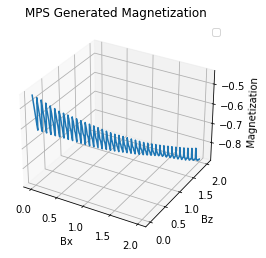

In [9]:
mps_size = 5
model = auto_encoder.MPS_autoencoder(mps_size = mps_size)

from mpl_toolkits import mplot3d
    
get_dataset = auto_encoder.get_dataset
data_6 = '6_qubit_crit_data.npz'
data_sizes = [6]
val_data_6 = get_dataset(data_6,6,1600)
mag_dat = [val_data_6]
print(len(training_data_4))
mag_loaders = [DataLoader(x, batch_size=len(val_data_6), num_workers=20) for x in mag_dat]

model.eval()
with torch.no_grad():
    for j,loader in enumerate(mag_loaders):
        sys_size = data_sizes[j]
        wave_functions = []
        true_wave = []
        for i, (fields,wf) in enumerate(loader):
            fields = fields
            gs = model(fields, sys_size)
            wave_functions.append(gs)
            true_wave.append(wf)

        system = (wave_functions,true_wave)


data_y_6 = system[0][0].numpy()
data_y_6_t = system[1][0].numpy()


vec_6 = seq_to_magnetization(seq_gen(6),6).reshape((64,1))
mag_6 = np.squeeze((np.power(data_y_6,2) @ vec_6))
mag_6_t = np.squeeze((np.power(data_y_6_t,2) @ vec_6))


x = np.linspace(0,2,1600)
y = np.linspace(0,2,1600)
#x, y = np.meshgrid(x, y)
fig = plt.figure()
ax1 = plt.axes(projection='3d')
ax1.plot3D(x, y, mag_6)



#ax1.plot(x,mag_4, label='4 Qubits')

#ax2.plot(x,mag_4_t, label='4 Qubits')


ax1.legend()
#ax2.legend()
ax1.set_title("MPS Generated Magnetization")
ax1.set_xlabel("Bx")
ax1.set_ylabel("Bz")
ax1.set_zlabel("Magnetization")
#ax1.title('J=1, Bz=0.01')



No handles with labels found to put in legend.


Text(0.5, 0, 'Magnetization')

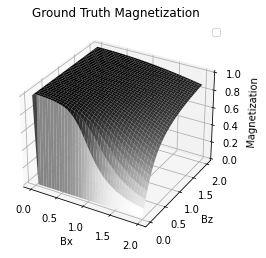

In [10]:
from mpl_toolkits.mplot3d import Axes3D
data = np.load(data_6)
Bx = data['fields'].T[6]
Bz = data['fields'].T[12]


# fig = plt.figure()
# ax = plt.axes(projection='3d')
# ax.plot3D(Bz, Bx, mag_4_t)

x = np.reshape(Bx, (40, 40))
y = np.reshape(Bz, (40, 40))
z = np.reshape(mag_4_t, (40, 40))


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(x, y, z, cmap="binary")

ax.legend()
ax.set_title("Ground Truth Magnetization")
ax.set_xlabel("Bx")
ax.set_ylabel("Bz")
ax.set_zlabel("Magnetization")

# file1 = open("mag4q.dat", "a") 
# for i in list:
#     file1.write(f"{mag_4_t[i]}\n")
# file1.close()


# file2 = open("Bx4q.dat", "a") 
# for i in list:
#     file2.write(f"{Bx[i]}\n")
# file2.close()

# file3 = open("Bz4q.dat", "a") 
# for i in list:
#     file3.write(f"{Bz[i]}\n")
# file3.close()


Text(0.5, 0, 'Magnetization')

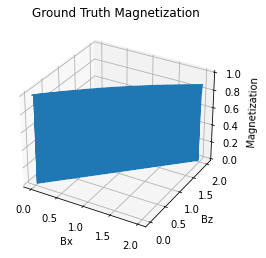

In [7]:
ax2 = plt.axes(projection='3d')
ax2.plot3D(x, y, mag_4_t)
ax2.set_title("Ground Truth Magnetization")
ax2.set_xlabel("Bx")
ax2.set_ylabel("Bz")
ax2.set_zlabel("Magnetization")

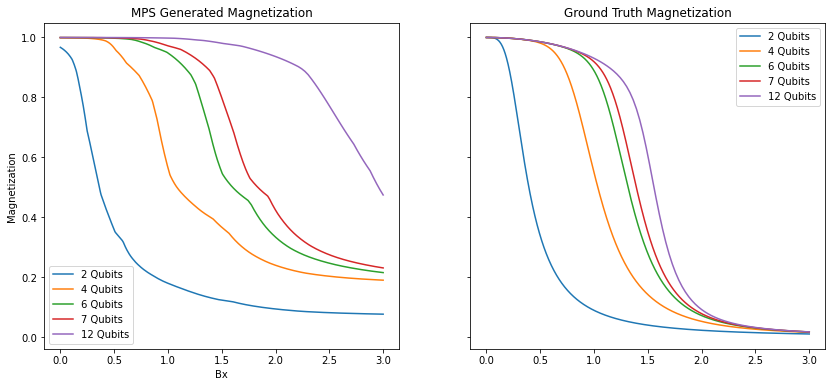

In [30]:
gen_graph(model)

In [15]:
torch.save(model.state_dict(), "2_site_model.pt")

In [16]:
def get_model(mps_size):
    PATH = "{}_site_model.pt".format(mps_size)
    device = torch.device('cpu')
    model = auto_encoder.MPS_autoencoder(mps_size)
    model.load_state_dict(torch.load(PATH, map_location=device))
    return model 

In [17]:
#model = get_model(2)

with torch.no_grad():
    encoded_spin_up = []
    encoded_spin_down = []
    
    
#     for i,(fields,wf) in enumerate(val_loader_4):
#         spin_up, spin_down = model.encode(fields)
#         print(spin_up.squeeze().shape)
#         print(spin_down.squeeze().shape)
#         encoded_spin_up.append(spin_up.squeeze())
#         encoded_spin_down.append(spin_down.squeeze())
        
#     for i,(fields,wf) in enumerate(val_loader_7):
#         spin_up, spin_down = model.encode(fields)
#         print(spin_up.squeeze().shape)
#         print(spin_down.squeeze().shape)
#         encoded_spin_up.append(spin_up.squeeze())
#         encoded_spin_down.append(spin_down.squeeze())
        
    for i,(fields,wf) in enumerate(training_loaders[0]):
        spin_up, spin_down = model.encode(fields)
        #print(fields)
        #print(spin_up.squeeze().shape)
        #print(spin_down.squeeze().shape)
        encoded_spin_up.append(spin_up.squeeze())
        encoded_spin_down.append(spin_down.squeeze())
        
    for i,(fields,wf) in enumerate(training_loaders[1]):
        spin_up, spin_down = model.encode(fields)
        #print(spin_up.squeeze().shape)
        #print(spin_down.squeeze().shape)
        encoded_spin_up.append(spin_up.squeeze())
        encoded_spin_down.append(spin_down.squeeze())  

/home/jszacha1/.conda/envs/conda_env/lib/python3.9/site-packages/torch/utils/data/dataloader.py:474: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 6, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [18]:
#model = get_model(2)

with torch.no_grad():
    encoded_spin_up = []
    encoded_spin_down = []        
       
    for i,(fields,wf) in enumerate(val_loaders[0]):
        spin_up, spin_down = model.encode(fields)
#         print(fields)
#         print(spin_up.squeeze().shape)
#         print(spin_down.squeeze().shape)
        encoded_spin_up.append(spin_up.squeeze())
        encoded_spin_down.append(spin_down.squeeze())
        
    for i,(fields,wf) in enumerate(val_loaders[1]):
        spin_up, spin_down = model.encode(fields)
#         print(spin_up.squeeze().shape)
#         print(spin_down.squeeze().shape)
        encoded_spin_up.append(spin_up.squeeze())
        encoded_spin_down.append(spin_down.squeeze())  

In [19]:
data_up = encoded_spin_up[0].numpy()
data_down = encoded_spin_down[0].numpy()
for i in range(1, len(encoded_spin_up)):
    data_up = np.vstack((data_up, encoded_spin_up[i].numpy()))
    data_down = np.vstack((data_down, encoded_spin_down[i].numpy()))
    
print(data_up.shape)
print(data_down.shape)

(1100, 5, 5)
(1100, 5, 5)


In [20]:
data_up = data_up.reshape((data_up.shape[0],25))
data_down = data_down.reshape((data_up.shape[0],25))

In [21]:
np.savetxt("mps_2_up_matrix.csv", data_up, delimiter=",")
np.savetxt("mps_2_down_matrix.csv", data_down, delimiter=",")

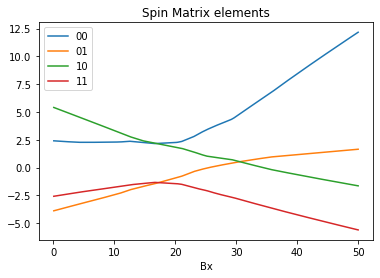

In [22]:
x = np.arange(1,1001)
x = x / (100) * 5

plt.plot(x,data_up[0:1000,0], label='00')
plt.plot(x,data_up[0:1000,1], label='01')
plt.plot(x,data_up[0:1000,2], label='10')
plt.plot(x,data_up[0:1000,3], label='11')
plt.xlabel('Bx')
plt.title('Spin Matrix elements')
plt.legend()

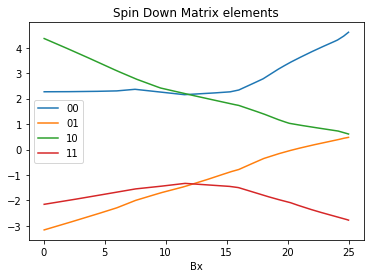

In [23]:
x = np.arange(1,501)
x = x / (100) * 5
k = 2
m = k-1
plt.plot(x,data_up[100*m:300*k,0], label='00')
plt.plot(x,data_up[100*m:300*k,1], label='01')
plt.plot(x,data_up[100*m:300*k,2], label='10')
plt.plot(x,data_up[100*m:300*k,3], label='11')
plt.xlabel('Bx')
plt.title('Spin Down Matrix elements')
plt.legend()

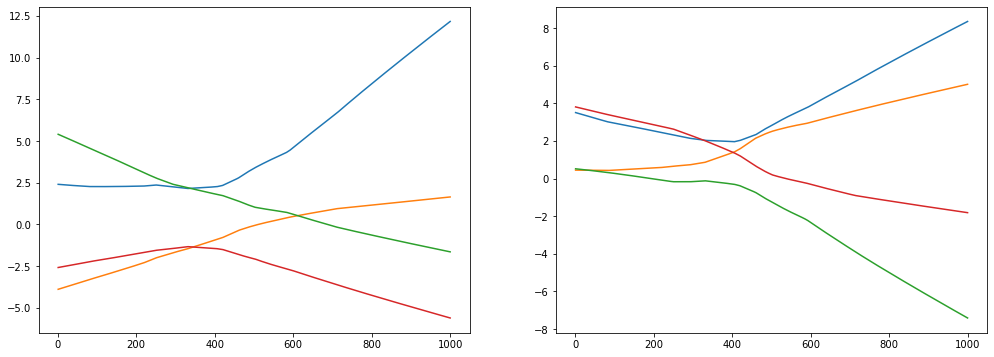

In [24]:
x = np.arange(1,1001)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(17,6))

for i in range(4):
    for k in range(1):
        ax1.plot(x,data_up[100*k:1000*(k+1),i])
        ax2.plot(x,data_down[100*k:1000*(k+1),i])


(1100, 50)
(100,)


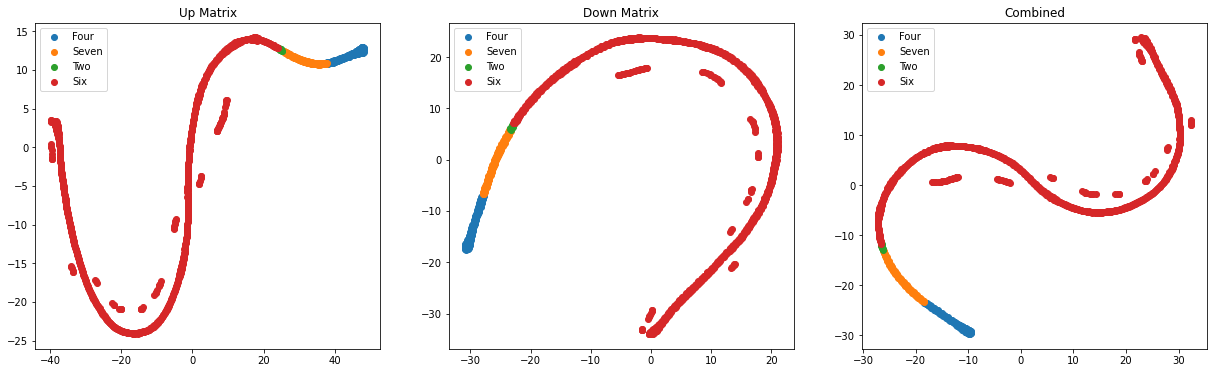

In [25]:
import numpy as np
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

up=data_up
down=data_down
data = np.hstack((data_up, data_down))

print(data.shape)

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(21,6))

pca = TSNE(n_components=2, perplexity=50)

up = pca.fit_transform(up)
down = pca.fit_transform(down)
data = pca.fit_transform(data)

print(up[:100][:,0].shape)
ax1.scatter(up[:100][:,0],up[:100][:,1] ,label='Four')
ax1.scatter(up[100:200][:,0],up[100:200][:,1] ,label='Seven')
ax1.scatter(up[200:210][:,0],up[200:210][:,1] ,label='Two')
ax1.scatter(up[210:][:,0],up[210:][:,1] ,label='Six')
ax1.set_title('Up Matrix')

ax1.legend()

ax2.scatter(down[:100][:,0],down[:100][:,1] ,label='Four')
ax2.scatter(down[100:200][:,0],down[100:200][:,1] ,label='Seven')
ax2.scatter(down[200:210][:,0],down[200:210][:,1] ,label='Two')
ax2.scatter(down[210:][:,0],down[210:][:,1] ,label='Six')
ax2.set_title('Down Matrix')

ax2.legend()

ax3.scatter(data[:100][:,0],data[:100][:,1] ,label='Four')
ax3.scatter(data[100:200][:,0],data[100:200][:,1] ,label='Seven')
ax3.scatter(data[200:210][:,0],data[200:210][:,1] ,label='Two')
ax3.scatter(data[210:][:,0],data[210:][:,1] ,label='Six')
ax3.set_title('Combined')
ax3.legend()


#scaled by 1/10 from old code

(1000,)


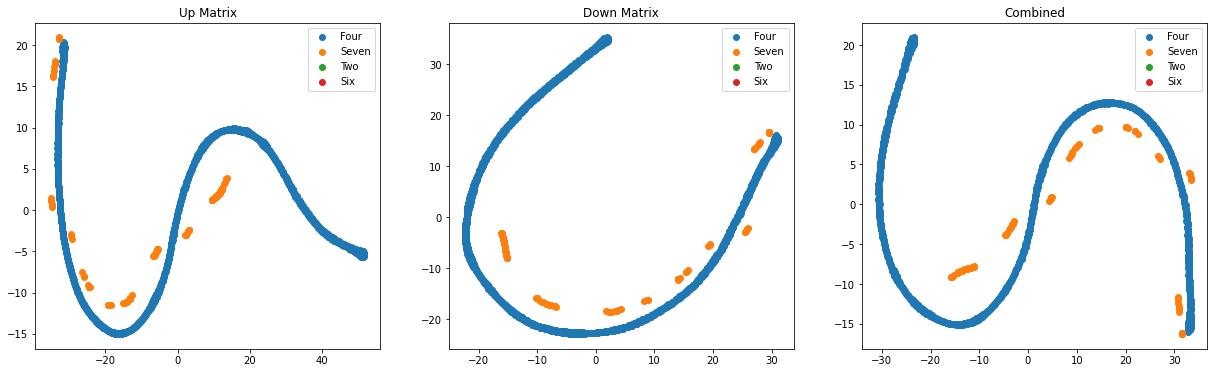

In [26]:
from sklearn.decomposition import PCA
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(21,6))

pca = PCA(n_components=2)

up = pca.fit_transform(up)
down = pca.fit_transform(down)
data = pca.fit_transform(data)

print(up[:1000][:,0].shape)
ax1.scatter(up[:1000][:,0],up[:1000][:,1] ,label='Four')
ax1.scatter(up[1000:2000][:,0],up[1000:2000][:,1] ,label='Seven')
ax1.scatter(up[2000:2100][:,0],up[2000:2100][:,1] ,label='Two')
ax1.scatter(up[2100:][:,0],up[2100:][:,1] ,label='Six')
ax1.set_title('Up Matrix')

ax1.legend()

ax2.scatter(down[:1000][:,0],down[:1000][:,1] ,label='Four')
ax2.scatter(down[1000:2000][:,0],down[1000:2000][:,1] ,label='Seven')
ax2.scatter(down[2000:2100][:,0],down[2000:2100][:,1] ,label='Two')
ax2.scatter(down[2100:][:,0],down[2100:][:,1] ,label='Six')
ax2.set_title('Down Matrix')

ax2.legend()

ax3.scatter(data[:1000][:,0],data[:1000][:,1] ,label='Four')
ax3.scatter(data[1000:2000][:,0],data[1000:2000][:,1] ,label='Seven')
ax3.scatter(data[2000:2100][:,0],data[2000:2100][:,1] ,label='Two')
ax3.scatter(data[2100:][:,0],data[2100:][:,1] ,label='Six')
ax3.set_title('Combined')
ax3.legend()